In [11]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [62]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [51]:
transform = transforms.Compose([
    # resize
    transforms.Resize(28),
    # center-crop
    transforms.CenterCrop(28),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.5], [0.5])
])

In [52]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

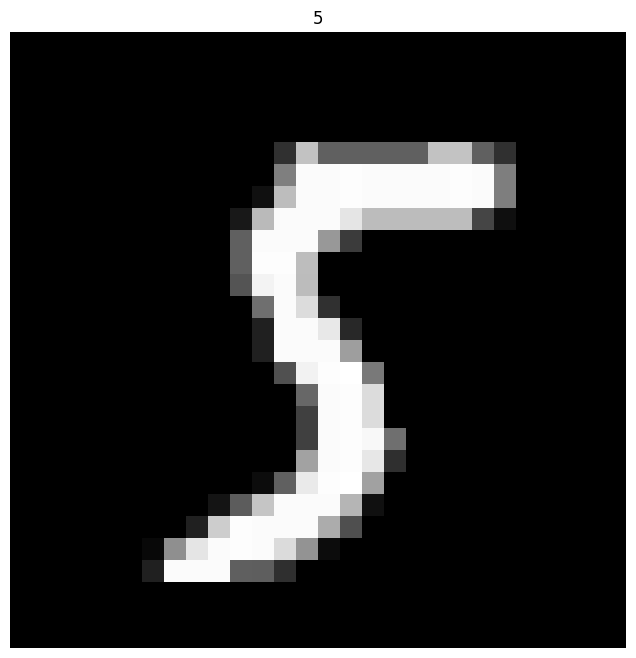

In [53]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 1, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    # print(img)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [54]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


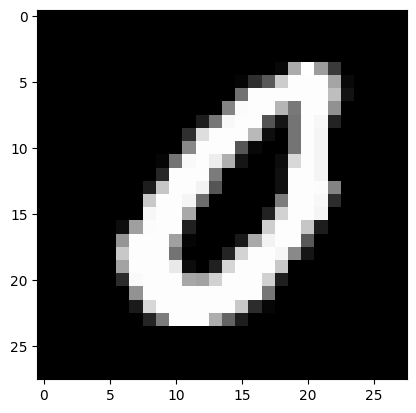

Label: 0


In [58]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [157]:
n = 28 * 28
n_hidden = 3000
n_outputs = 10
g = torch.Generator().manual_seed(2147483647) # for reproducibility
W1 = torch.randn((n, n_hidden)) * (1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32)))
b1 = torch.randn((1, n_hidden))
W2 = torch.randn((n_hidden, n_outputs)) * (1.0 / torch.sqrt(torch.tensor(n_hidden, dtype=torch.float32)))
b2 = torch.randn((1, n_outputs))
batch_size = 64

parameters = [W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

2385010


In [158]:
learning_rate = 0.01
steps = 50000
for step in range(steps):
    train_features, train_labels = next(iter(train_dataloader))
    x = train_features.squeeze()
    x_vec = x.view((batch_size, n))
    h1 = x_vec @ W1 + b1
    h1_activated = torch.relu(h1)
    logits = h1_activated @ W2 + b2
    loss = F.cross_entropy(logits, train_labels)

    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data -= learning_rate * p.grad

    if step % 100 == 0:
        print(f"{step}/{steps}; loss={loss}")

0/50000; loss=3.0350077152252197
100/50000; loss=0.7424196600914001
200/50000; loss=0.4825699031352997
300/50000; loss=0.36728546023368835
400/50000; loss=0.2472168505191803
500/50000; loss=0.27350887656211853
600/50000; loss=0.2644270956516266
700/50000; loss=0.39904850721359253
800/50000; loss=0.40185779333114624
900/50000; loss=0.45685169100761414
1000/50000; loss=0.2969614565372467
1100/50000; loss=0.41255253553390503
1200/50000; loss=0.3473416268825531
1300/50000; loss=0.3254193961620331
1400/50000; loss=0.4665276110172272
1500/50000; loss=0.32677140831947327
1600/50000; loss=0.1929471343755722
1700/50000; loss=0.29787498712539673
1800/50000; loss=0.21959686279296875
1900/50000; loss=0.25730928778648376
2000/50000; loss=0.17123626172542572
2100/50000; loss=0.3819717466831207
2200/50000; loss=0.19093218445777893
2300/50000; loss=0.32230907678604126
2400/50000; loss=0.257625550031662
2500/50000; loss=0.28718024492263794
2600/50000; loss=0.3265162408351898
2700/50000; loss=0.29353812

Expected label: 3; got label: 8


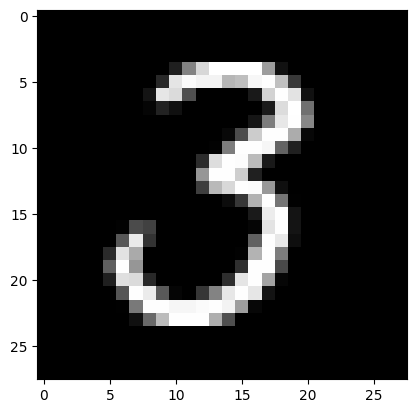

Label: 3


In [168]:
test_features, test_labels = next(iter(test_dataloader))
img = test_features.squeeze()[0]
label = test_labels[0]
img_vec = img.view((-1, n))
h1 = img_vec @ W1 + b1
h1_activated = torch.tanh(h1)
h2 = h1_activated @ W2 + b2
probs = h2.softmax(dim=1)
ix = torch.multinomial(probs, num_samples=1, generator=g).item()

print(f"Expected label: {label}; got label: {ix}")

plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [169]:
test_loss = 0.0
total_samples = 0

with torch.no_grad():  # Disable gradient computation for efficiency
    for test_features, test_labels in test_dataloader:
        test_features = test_features.squeeze()  # Remove unnecessary channel dimension
        batch_size = test_features.shape[0]
        n = test_features.numel() // batch_size  # Flatten dimension calculation

        # Reshape input (flatten images)
        x_vec = test_features.view(batch_size, -1)  # Shape: (batch_size, n)

        # Forward pass
        h1 = x_vec @ W1 + b1
        h1_activated = torch.tanh(h1)
        h2 = h1_activated @ W2 + b2
        h2_activated = F.softmax(h2, dim=1)  # Output probabilities

        # Compute loss
        loss = F.cross_entropy(h2_activated, test_labels)  # Compute batch loss
        test_loss += loss.item() * batch_size  # Sum up weighted batch loss
        total_samples += batch_size

# Compute average loss
average_test_loss = test_loss / total_samples
print(f"Average Test Loss: {average_test_loss:.4f}")

Average Test Loss: 2.0476


In [176]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super().__init__()
        layers = []
        prev_size = input_size

        # Hidden layers with ReLU activation
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size  

        # Output layer (no activation, handled by CrossEntropyLoss)
        layers.append(nn.Linear(prev_size, output_size))

        # Combine into Sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_model(model, train_dataloader, device="cpu", learning_rate=0.01):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    total_loss = 0
    model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)  # Flatten images

        # Forward pass
        logits = model(images)
        loss = loss_fn(logits, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(train_dataloader)

def evaluate_model(model, test_dataloader, device="cpu"):
    correct, total = 0, 0
    test_loss = 0
    loss_fn = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.shape[0], -1)

            logits = model(images)
            test_loss += loss_fn(logits, labels).item()

            predicted = logits.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def objective(trial):
    # Hyperparameter optimization space
    input_size = 28 * 28
    output_size = 10
    # Define search spaces
    hidden_layers = []
    num_layers = trial.suggest_int("num_layers", 1, 4)  # Search 1-3 hidden layers
    for _ in range(num_layers):
        hidden_layers.append(trial.suggest_int("hidden_layer_size", 32, 512))  # Search for neurons between 32 and 512
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)  # Log scale search space

    # Create Model
    model = MLP(input_size, hidden_layers, output_size)
    
    # Training
    train_loss = train_model(model, train_dataloader, learning_rate=learning_rate)
    
    # Evaluation
    val_loss, val_accuracy = evaluate_model(model, test_dataloader)
    
    # Return the validation loss as the objective to minimize
    return val_loss  # Or use val_accuracy to maximize instead


In [177]:
# Set up the Optuna study
study = optuna.create_study(direction='minimize')  # For loss, or 'maximize' for accuracy
study.optimize(objective, n_trials=50)  # You can change n_trials for more trials

# Best hyperparameters found
print(f"Best hyperparameters: {study.best_params}")


[I 2025-03-10 22:53:58,523] A new study created in memory with name: no-name-9b3a719f-9996-4d57-a413-5e28a2defa0f
[I 2025-03-10 22:54:02,184] Trial 0 finished with value: 0.3125288727082265 and parameters: {'num_layers': 1, 'hidden_layer_size': 66, 'learning_rate': 0.0004272276802226957}. Best is trial 0 with value: 0.3125288727082265.
[I 2025-03-10 22:54:08,251] Trial 1 finished with value: 2.30581873541425 and parameters: {'num_layers': 3, 'hidden_layer_size': 508, 'learning_rate': 0.08950705014219264}. Best is trial 0 with value: 0.3125288727082265.
[I 2025-03-10 22:54:13,071] Trial 2 finished with value: 0.24748259308231865 and parameters: {'num_layers': 3, 'hidden_layer_size': 326, 'learning_rate': 0.007842227595957995}. Best is trial 2 with value: 0.24748259308231865.
[I 2025-03-10 22:54:17,027] Trial 3 finished with value: 0.7288226004998395 and parameters: {'num_layers': 1, 'hidden_layer_size': 504, 'learning_rate': 0.04387233981288631}. Best is trial 2 with value: 0.2474825930

Best hyperparameters: {'num_layers': 2, 'hidden_layer_size': 96, 'learning_rate': 0.0036495723110907133}


In [180]:
# Step 1: Retrieve best hyperparameters found by Optuna
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Step 2: Set up the model using the best hyperparameters
input_size = 28 * 28  # Input size for the FashionMNIST dataset
output_size = 10  # Number of classes in the FashionMNIST dataset

# Extract best parameters
hidden_layers = []
num_layers = best_params["num_layers"]  # Number of layers
for _ in range(num_layers):
    hidden_layers.append(best_params["hidden_layer_size"])  # Number of neurons per hidden layer
learning_rate = best_params["learning_rate"]

# Create the model
model = MLP(input_size, hidden_layers, output_size)

Best hyperparameters: {'num_layers': 2, 'hidden_layer_size': 96, 'learning_rate': 0.0036495723110907133}


In [185]:
# Step 3: Train the model using the best hyperparameters
# Train the model on your dataset
train_loss = train_model(model, train_dataloader, learning_rate=learning_rate)
print(f"Training loss with best parameters: {train_loss}")

# Step 4: Evaluate the model on the test set
val_loss, val_accuracy = evaluate_model(model, test_dataloader)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}%")

Training loss with best parameters: 0.1303398988248387
Validation Loss: 0.1473248930066634
Validation Accuracy: 95.67%


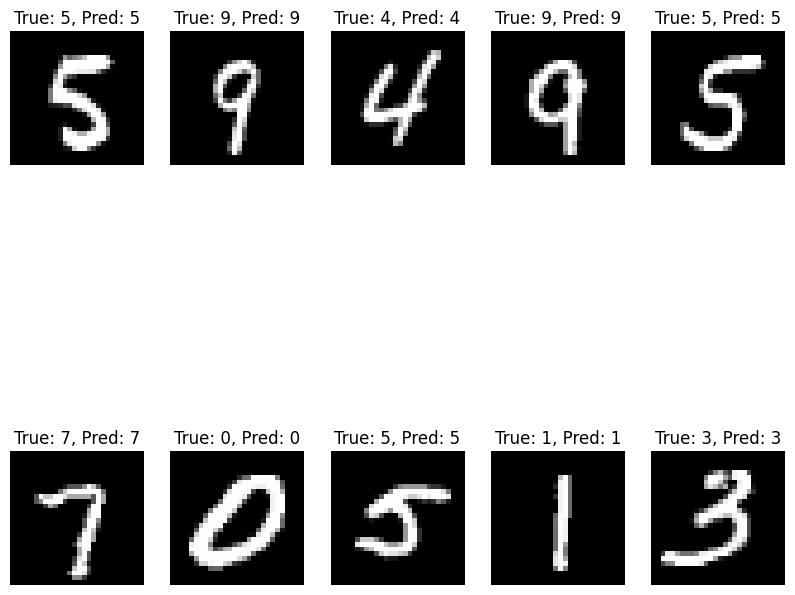

In [187]:
# Function to display a grid of images and their predicted labels
def plot_images_with_labels(model, dataloader, device="cpu"):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(dataloader))  # Sample a batch from the dataloader

    images, labels = images.to(device), labels.to(device)
    images = images.view(images.shape[0], -1)  # Flatten the images (28*28)

    # Get predictions from the model
    logits = model(images)
    predicted_labels = logits.argmax(dim=1)  # Get the predicted labels

    # Plot images and labels
    figure = plt.figure(figsize=(10, 10))
    for i in range(10):  # Show the first 10 images in the batch
        ax = figure.add_subplot(2, 5, i + 1)  # Create a 2x5 grid
        ax.imshow(images[i].cpu().view(28, 28).detach().numpy(), cmap="gray")
        ax.set_title(f"True: {labels[i].item()}, Pred: {predicted_labels[i].item()}")
        ax.axis("off")

    plt.show()

# Sample usage: Call this function after training your model
plot_images_with_labels(model, test_dataloader, device="cpu")